In [1]:
!git clone https://github.com/shariqfarhan/EVA8-pytorch-cifar

Cloning into 'EVA8-pytorch-cifar'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [2]:
import os
os.chdir('EVA8-pytorch-cifar')
os.listdir()

['.git', 'train.py', 'README.md', 'test_model.py', 'utils', 'models']

In [7]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchinfo import summary
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt



from models import resnet
from utils.utils import get_mean_and_std, show_data_metrics, viz_data, show_images, show_model_summary
from utils.utils import AlbumentationImageDataset, plot_train_test_acc_loss, plot_misclassified_images, denormalize, plot_gradcam
from train import train
from test_model import test, mis_classified_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

exp = datasets.CIFAR10('./data', train = True, download = True)
exp_data = exp.data

show_data_metrics(exp_data)


100%|██████████| 170498071/170498071 [00:04<00:00, 34241068.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Train
- Numpy Shape : (50000, 32, 32, 3)
- min : [0. 0. 0.]
- max : [1. 1. 1.]
- mean : [0.49139968 0.48215841 0.44653091]
- std. : [0.24703223 0.24348513 0.26158784]
- var : [15.56135559 15.11767693 17.44919073]


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

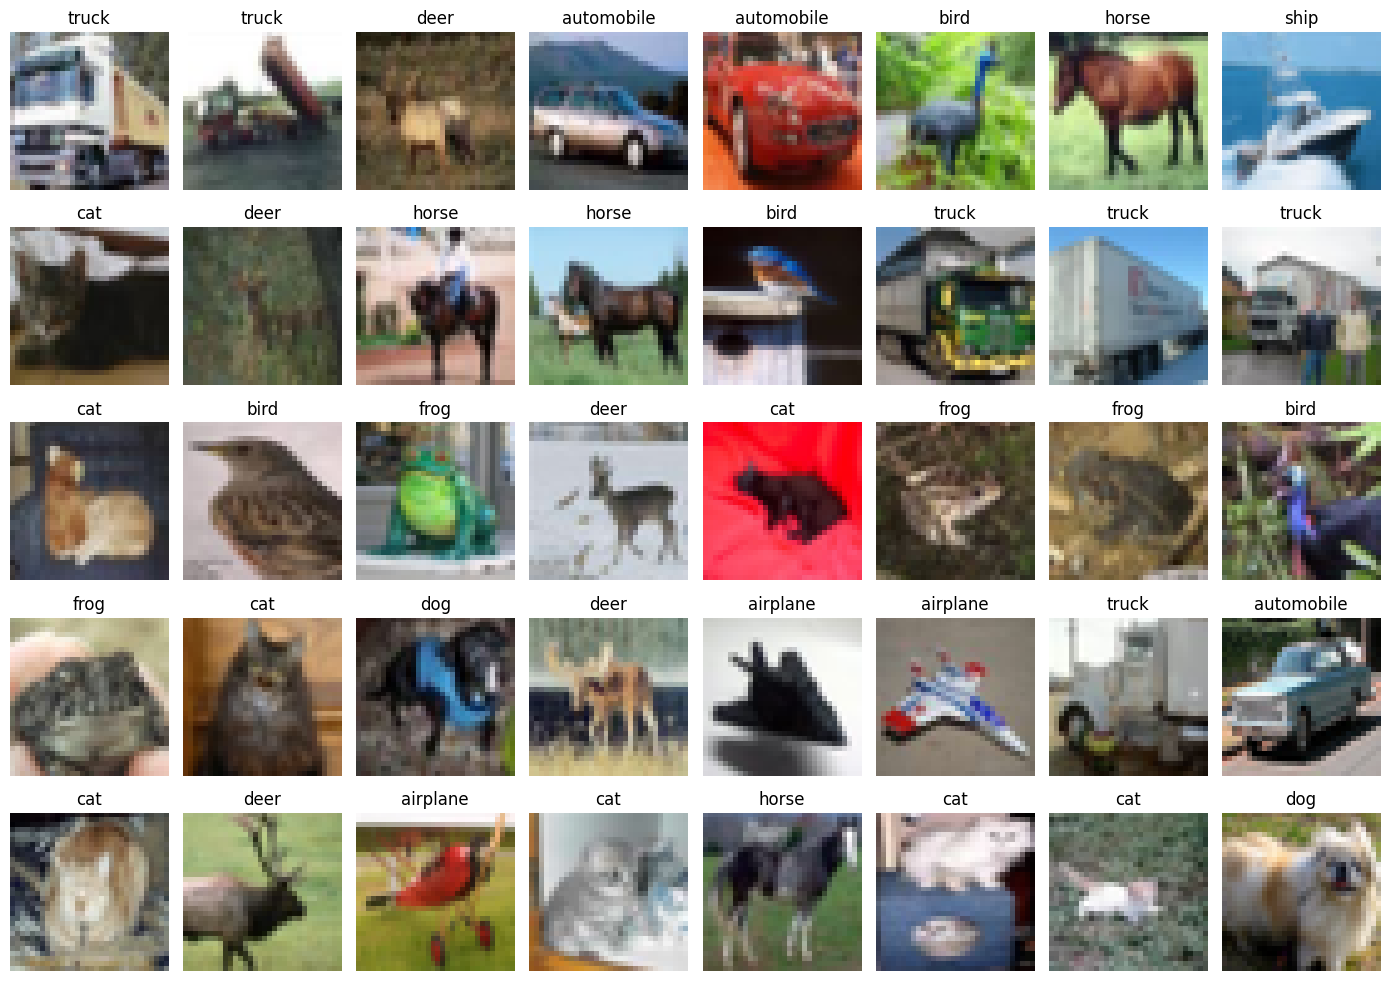

In [8]:
viz_data(exp)

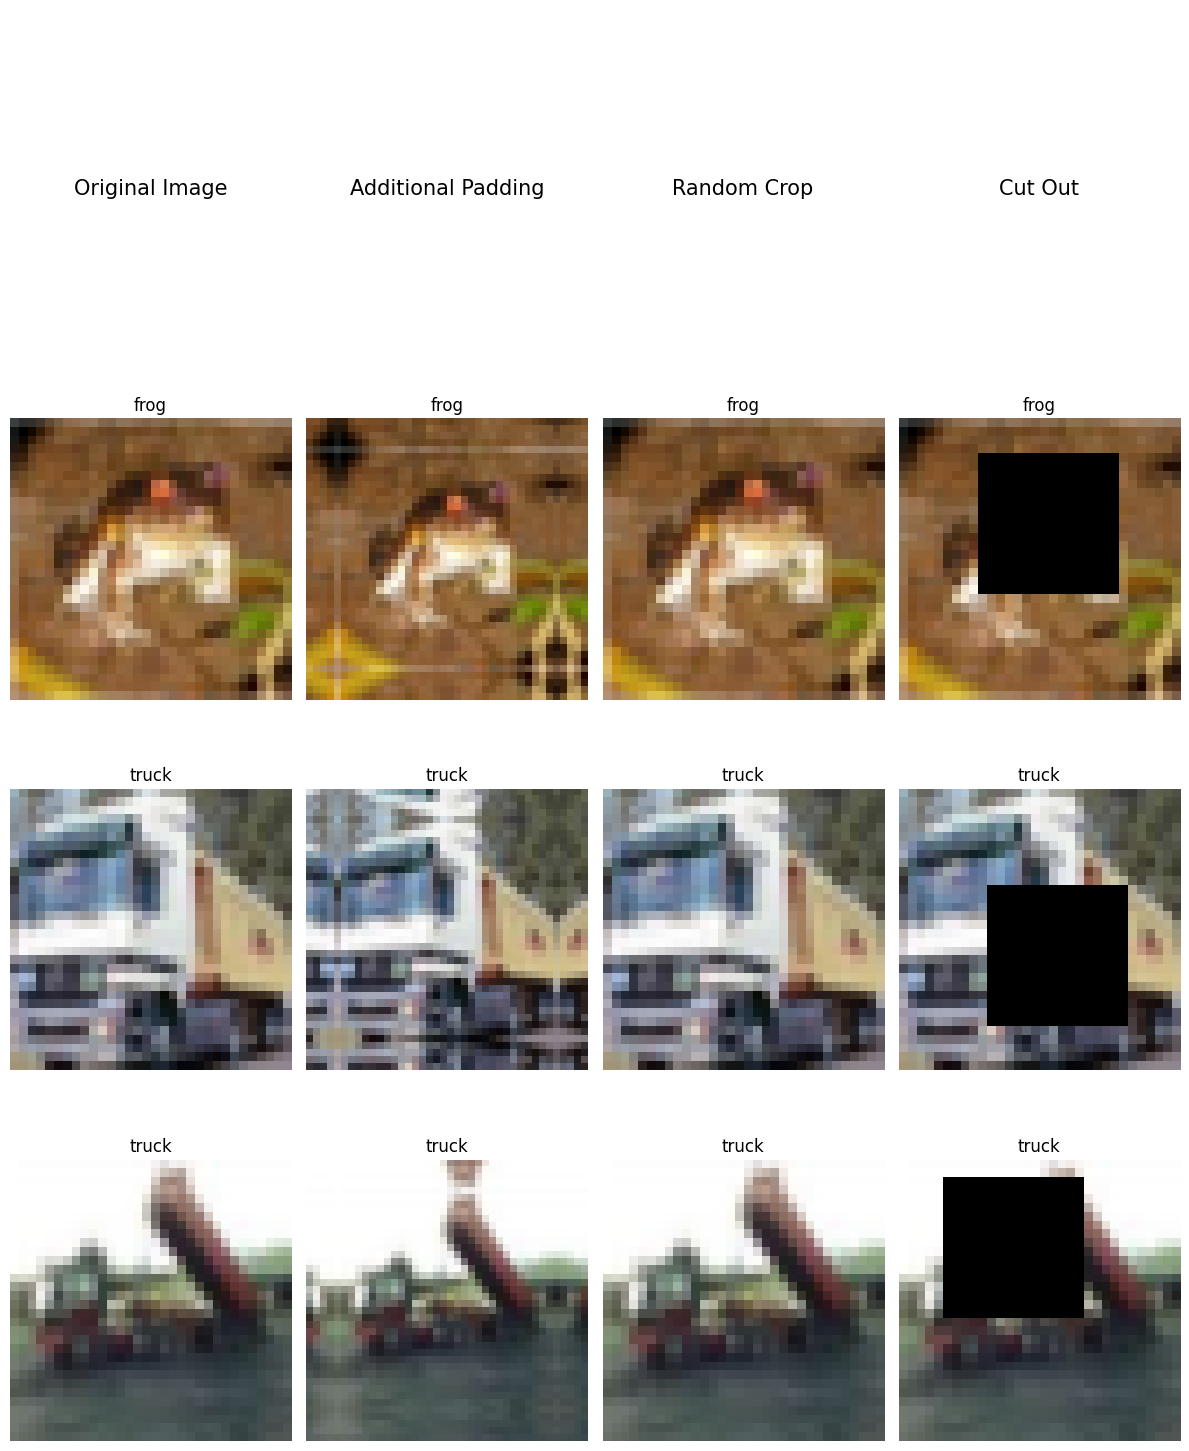

In [9]:
# RandomCrop(32, padding=4)
# CutOut(16x16)
show_images(exp,{
    'Original Image' : None,
    'Additional Padding' : A.PadIfNeeded(min_height=40, min_width=40), # Padding on both sides equal to 4 -> 32 + 2*4 = 40
    'Random Crop' : A.RandomCrop(32, 32),
    'Cut Out' : A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                                min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True)
}, ncol = 4)

In [10]:
# session_parameters()
SEED = 1

# CUDA
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For Reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE = 64
else:
    BATCH_SIZE = 64

CUDA Available: True


In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, 
                                        download = True)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, 
                                        download = True)

train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train = True),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train = False),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
from models import *
from models.resnet import ResNet18
model = ResNet18()
show_model_summary(model)

cuda
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [16, 64, 32, 32]          128
├─Sequential: 1-3                        [16, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [16, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [16, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 32, 32]          128
│    │    └─Conv2d: 3-3                  [16, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-4             [16, 64, 32, 32]          128
│    │    └─Sequential: 3-5              [16, 64, 32, 32]          --
│    └─BasicBlock: 2-2                   [16, 64, 32, 32]          --
│    │    └─Conv2d: 3-6                  [16, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-7             [16, 64, 32, 32]     

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
EPOCHS = 20

model = ResNet18().to(device)

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_losses, train_acc, test_losses, test_acc = list(), list(), list(), list()
for epoch in range(1, EPOCHS+1):
    print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, train_loader, optimizer, criterion, train_losses, train_acc, l1_penalty = True, lambda_l1 = 1e-5)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 1 (LR: 0.01)


Loss=2.4372575283050537 Batch_id=781 Accuracy=38.18: 100%|██████████| 782/782 [00:37<00:00, 21.03it/s]



Test set: Average loss: -3.3378, Accuracy: 5802/10000 (58.02%)

EPOCH: 2 (LR: 0.01)


Loss=2.0401816368103027 Batch_id=781 Accuracy=52.83: 100%|██████████| 782/782 [00:37<00:00, 20.74it/s]



Test set: Average loss: -5.0625, Accuracy: 6825/10000 (68.25%)

EPOCH: 3 (LR: 0.01)


Loss=1.8356696367263794 Batch_id=781 Accuracy=59.70: 100%|██████████| 782/782 [00:37<00:00, 20.83it/s]



Test set: Average loss: -5.1034, Accuracy: 7265/10000 (72.65%)

EPOCH: 4 (LR: 0.01)


Loss=2.1858654022216797 Batch_id=781 Accuracy=63.28: 100%|██████████| 782/782 [00:37<00:00, 20.83it/s]



Test set: Average loss: -6.1370, Accuracy: 7395/10000 (73.95%)

EPOCH: 5 (LR: 0.01)


Loss=1.3729472160339355 Batch_id=781 Accuracy=66.28: 100%|██████████| 782/782 [00:37<00:00, 20.71it/s]



Test set: Average loss: -6.6055, Accuracy: 7495/10000 (74.95%)

EPOCH: 6 (LR: 0.01)


Loss=1.837242841720581 Batch_id=781 Accuracy=68.66: 100%|██████████| 782/782 [00:37<00:00, 20.98it/s] 



Test set: Average loss: -7.0673, Accuracy: 7930/10000 (79.30%)

EPOCH: 7 (LR: 0.01)


Loss=2.218010663986206 Batch_id=781 Accuracy=69.75: 100%|██████████| 782/782 [00:37<00:00, 20.70it/s] 



Test set: Average loss: -7.2671, Accuracy: 7872/10000 (78.72%)

EPOCH: 8 (LR: 0.01)


Loss=1.3488136529922485 Batch_id=781 Accuracy=71.54: 100%|██████████| 782/782 [00:37<00:00, 20.97it/s]



Test set: Average loss: -7.6757, Accuracy: 8201/10000 (82.01%)

EPOCH: 9 (LR: 0.01)


Loss=1.7038609981536865 Batch_id=781 Accuracy=72.36: 100%|██████████| 782/782 [00:37<00:00, 20.78it/s]



Test set: Average loss: -7.7558, Accuracy: 8211/10000 (82.11%)

EPOCH: 10 (LR: 0.01)


Loss=1.4642369747161865 Batch_id=781 Accuracy=73.21: 100%|██████████| 782/782 [00:37<00:00, 20.65it/s]



Test set: Average loss: -7.7845, Accuracy: 8229/10000 (82.29%)

EPOCH: 11 (LR: 0.01)


Loss=1.8160532712936401 Batch_id=781 Accuracy=74.17: 100%|██████████| 782/782 [00:38<00:00, 20.56it/s]



Test set: Average loss: -8.0763, Accuracy: 8297/10000 (82.97%)

EPOCH: 12 (LR: 0.01)


Loss=1.4931230545043945 Batch_id=781 Accuracy=74.92: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]



Test set: Average loss: -8.5894, Accuracy: 8300/10000 (83.00%)

EPOCH: 13 (LR: 0.01)


Loss=1.588808298110962 Batch_id=781 Accuracy=75.60: 100%|██████████| 782/782 [00:37<00:00, 20.67it/s] 



Test set: Average loss: -8.6215, Accuracy: 8101/10000 (81.01%)

EPOCH: 14 (LR: 0.01)


Loss=1.744088888168335 Batch_id=781 Accuracy=76.57: 100%|██████████| 782/782 [00:37<00:00, 20.94it/s] 



Test set: Average loss: -9.6370, Accuracy: 8345/10000 (83.45%)

EPOCH: 15 (LR: 0.01)


Loss=1.4941519498825073 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:37<00:00, 20.66it/s]



Test set: Average loss: -9.1359, Accuracy: 8484/10000 (84.84%)

EPOCH: 16 (LR: 0.01)


Loss=1.3103077411651611 Batch_id=781 Accuracy=77.18: 100%|██████████| 782/782 [00:37<00:00, 20.93it/s]



Test set: Average loss: -9.5423, Accuracy: 8219/10000 (82.19%)

EPOCH: 17 (LR: 0.01)


Loss=0.9820313453674316 Batch_id=781 Accuracy=77.56: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s]



Test set: Average loss: -9.3675, Accuracy: 8542/10000 (85.42%)

EPOCH: 18 (LR: 0.01)


Loss=1.1647119522094727 Batch_id=781 Accuracy=78.11: 100%|██████████| 782/782 [00:37<00:00, 20.64it/s]



Test set: Average loss: -9.1116, Accuracy: 8482/10000 (84.82%)

EPOCH: 19 (LR: 0.01)


Loss=1.4211103916168213 Batch_id=781 Accuracy=78.09: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]



Test set: Average loss: -9.3036, Accuracy: 8366/10000 (83.66%)

EPOCH: 20 (LR: 0.01)


Loss=0.7216936349868774 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:38<00:00, 20.53it/s]



Test set: Average loss: -9.1363, Accuracy: 8527/10000 (85.27%)



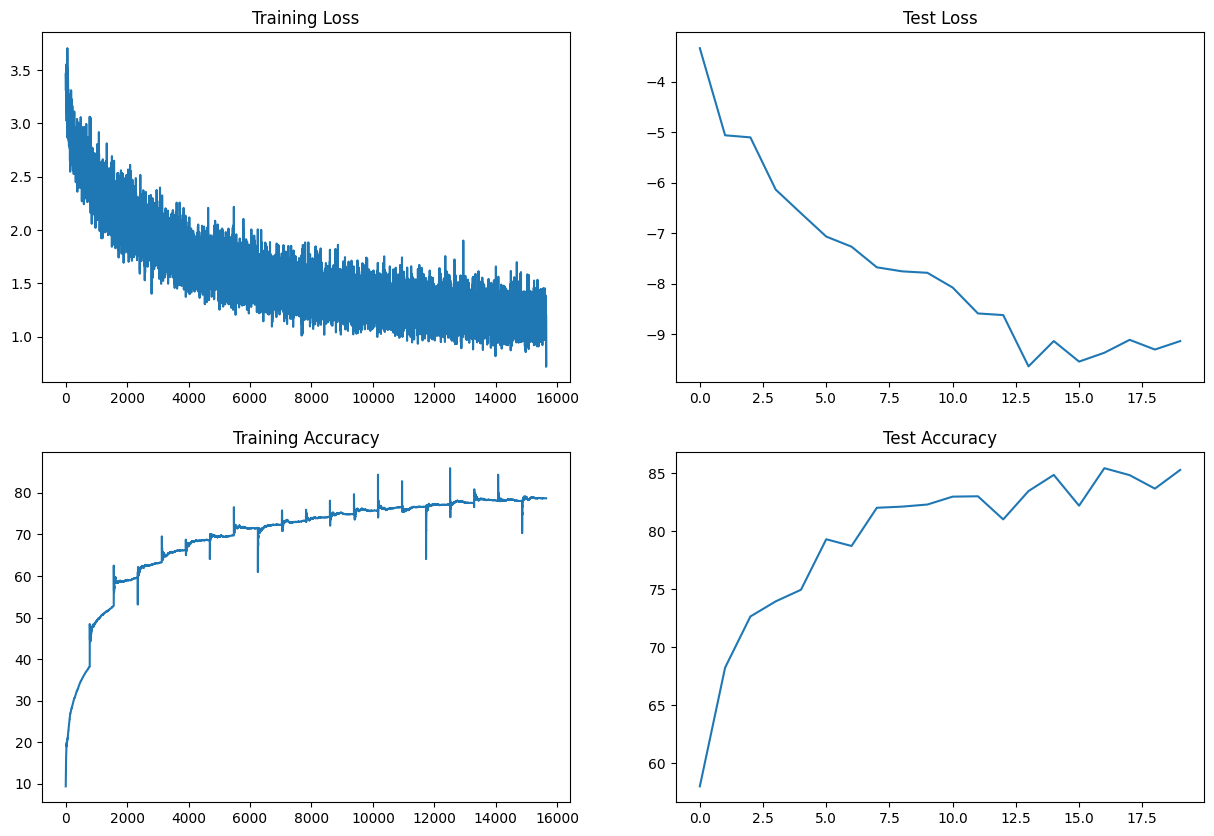

In [15]:
plot_train_test_acc_loss(train_losses, train_acc, test_losses, test_acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

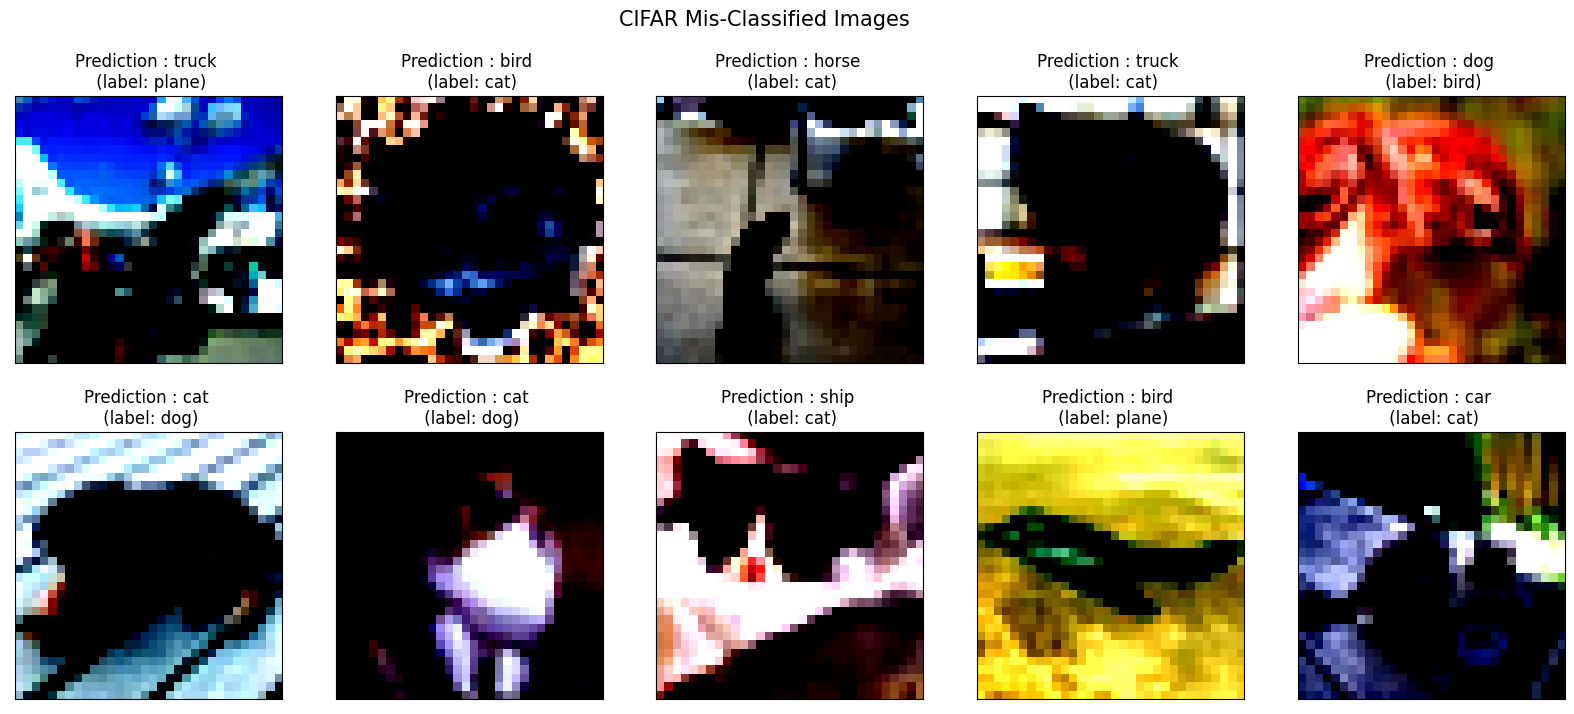

In [16]:


# Identify incorrect classifications
incorr_X, incorr_y, incorr_argmax = mis_classified_images(model, device, test_loader) 

#Plot the images
plot_misclassified_images(incorr_X, incorr_y, incorr_argmax, classes)

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2

/mnt/cephfs/hadoop-compute/phoenix/sfarhan/Explore/Deep Learning/EVA8-pytorch-cifar/utils/utils.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor)


<Figure size 3200x3200 with 0 Axes>

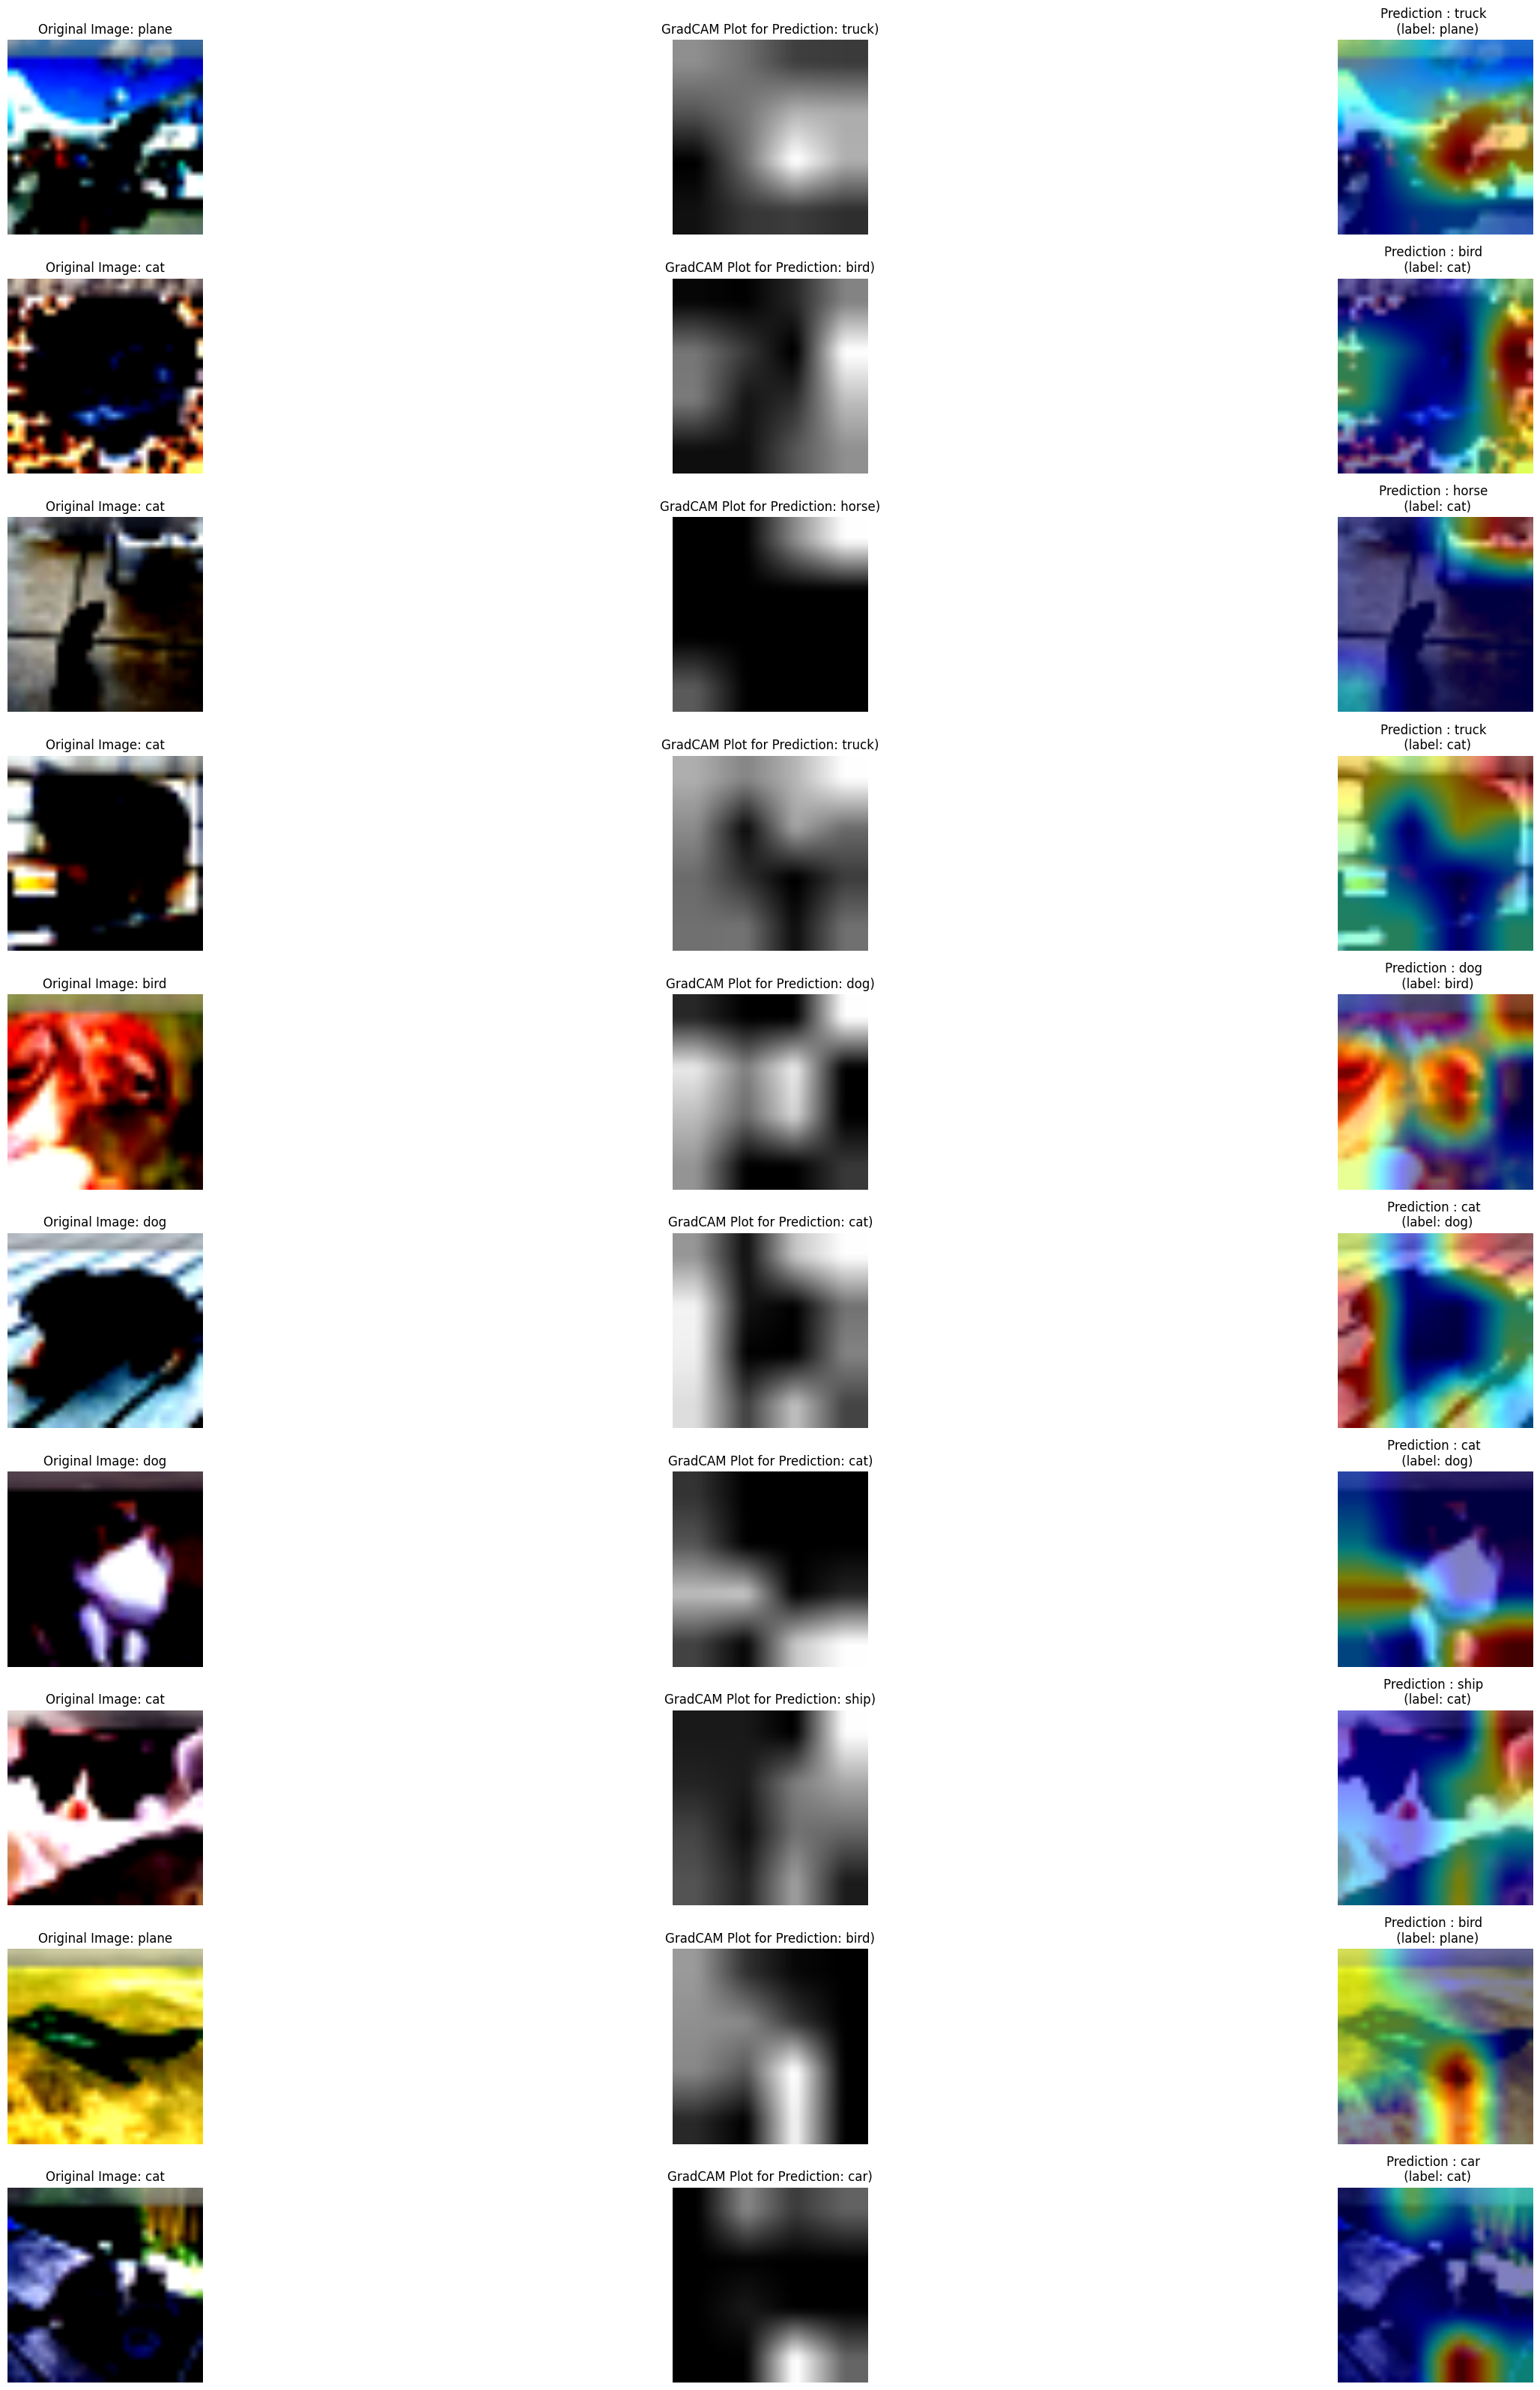

In [18]:
layer = [model.layer4[-2]]
plot_gradcam(model, incorr_X, incorr_y, incorr_argmax, classes ,layer, device, 10)